In [2]:
import sys
import os

current_path = os.path.abspath('')
parent_path = os.path.dirname(current_path)

if parent_path not in sys.path:
    sys.path.insert(0, parent_path)
    
import geopandas as gpd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import contextily as ctx
import seaborn as sns

from pointpats import PoissonPointProcess, as_window 
from libpysal.cg import Point, Polygon

# Visualization of Simulation Design

In [3]:
seed = 0 # set seed for replication
np.random.seed(seed)
square = Polygon([Point((0, 0)), Point((0, 2000)), Point((2000, 2000)), Point((2000, 0))])
squwin = as_window(square)

# Stations
np.random.seed(seed)
squsamples = PoissonPointProcess(squwin, 150, 1, conditioning=False, asPP=False)
squpts_random = squsamples.realizations[0]

# DataFrame for Stations
random_df = pd.DataFrame(squpts_random, columns = ['Lon', 'Lat'])
random_df = random_df.assign(Name = np.arange(random_df.shape[0]))
digits = len(str(150))
random_df.Name = random_df.Name.astype(str).str.zfill(digits).apply(lambda x: "{}{}".format('R', x))

# Add attributes, X1 and X2, for Stations
attr1 = np.random.uniform(2, 100, 150)
attr2 = np.random.uniform(100, 500, 150)

simul_stations = random_df.assign(X1 = attr1, X2 = attr2)

# POIs
np.random.seed(seed * 2)
squsamples_pois = PoissonPointProcess(squwin, 900, 1, conditioning=False, asPP=False)
squpts_pois = squsamples_pois.realizations[0]

# DataFrame for POIs
pois_df = pd.DataFrame(squpts_pois, columns = ['Lon', 'Lat'])
pois_df = pois_df.assign(Name = np.arange(pois_df.shape[0]))
digits = len(str(900))
pois_df.Name = pois_df.Name.astype(str).str.zfill(digits).apply(lambda x: "{}{}".format('I', x))

# Add attribute for POIs
attrI = np.ones(pois_df.shape[0])
simul_pois = pois_df.assign(AttributeI = attrI)

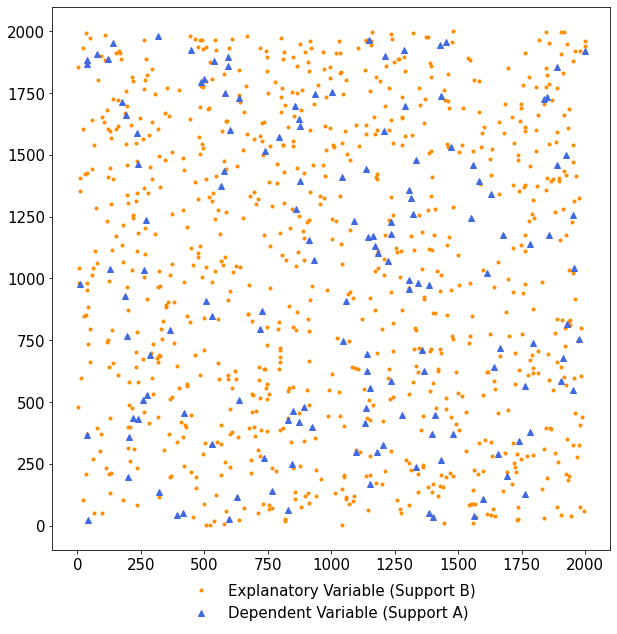

In [4]:
fig, ax = plt.subplots(figsize = (10,10))

ax.plot(simul_pois.Lon.to_numpy(), simul_pois.Lat.to_numpy(), '.', color='darkorange')
ax.plot(simul_stations.Lon.to_numpy(), simul_stations.Lat.to_numpy(),'^', color='royalblue')

ax.tick_params(axis='both', which='major', labelsize=15)

ax.legend(['Explanatory Variable (Support B)', 'Dependent Variable (Support A)'], fontsize = 15,
          loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1, borderaxespad=0, frameon=False) 

# loc='upper left', bbox_to_anchor=(1, 0.07), ncol=1, borderaxespad=0, frameon=False)
# loc='upper left', bbox_to_anchor=(0.5, -0.05), ncol=1, borderaxespad=0, frameon=False) 

plt.savefig("../results/simulation_design.png", dpi=300)

# Visualization of the Study Area of Empirical Case

In [5]:
boundary_study_area = gpd.read_file("../data/boundary_study_area.geojson") # Boundary of the Study area
cb_study_area = gpd.read_file("../data/cb_study_area.geojson") # Census Blocks within the Study area
stations_study_area = gpd.read_file("../data/stations_study_area.geojson") # Stations within the Study area (i.e., all bike stations in Brooklyn)
pois_study_area = gpd.read_file("../data/pois_study_area.geojson") # POIs within the Study area 

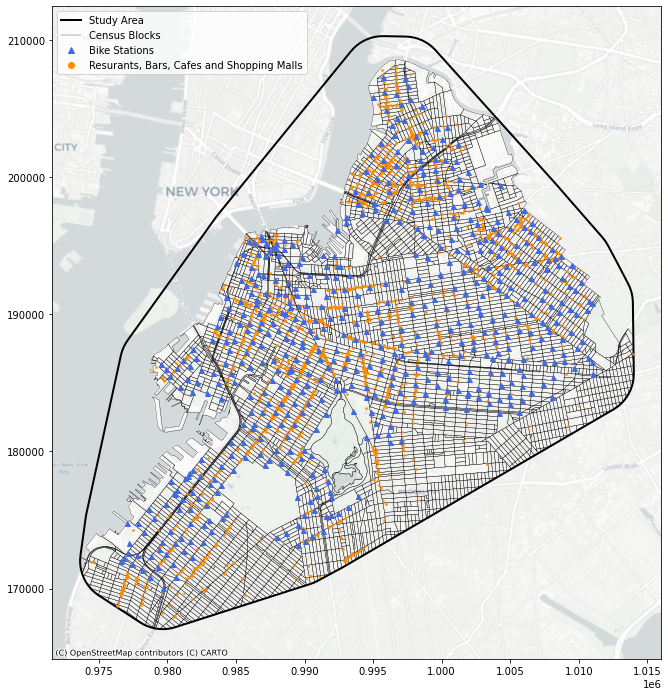

In [6]:
fig, ax = plt.subplots(figsize=(12,12))

boundary_study_area.boundary.plot(ax=ax, color='black', linewidth=2, label='Study Area') 
clipped_cb_study_area = gpd.clip(cb_study_area, boundary_study_area)
clipped_cb_study_area.boundary.plot(ax=ax, linewidth=0.3, edgecolor='black', label='Census Blocks')

ax.plot(pois_study_area.geometry.x.to_numpy(), pois_study_area.geometry.y.to_numpy(), '.', markersize=3, color='darkorange', label='Resurants, Bars, Cafes and Shopping Malls')
ax.plot(stations_study_area.geometry.x.to_numpy(), stations_study_area.geometry.y.to_numpy(), '^', markersize=5, color='royalblue', label='Bike Stations')

ctx.add_basemap(ax, crs=cb_study_area.crs.to_string(), source=ctx.providers.CartoDB.Positron)

legend_elements = [
    Line2D([0], [0], color='black',linewidth=2, label='Study Area', linestyle='-'),
    Line2D([0], [0], color='black', linewidth=0.3,label='Census Blocks', linestyle='-'),
    Line2D([0], [0], color='royalblue', label='Bike Stations', linestyle='None', marker='^'), 
    Line2D([0], [0], color='darkorange', label='Resurants, Bars, Cafes and Shopping Malls', linestyle='None', marker='o')  
]

# Add elements to legend.
ax.legend(handles=legend_elements, loc='upper left')

plt.savefig("../results/study_area.png", dpi=300)
plt.show()

# Visualization: Classic V.S Modified Backfitting

In [7]:
df_0_classic = pd.read_csv("../results/0%Noise_classic_pt5_1pt5.csv")
df_0_modified = pd.read_csv("../results/0%Noise_pt5_1pt5.csv")

# Remove one outlier from `sigma_s_pois`
# Calculate the IQR
Q1 = df_0_classic['sigma_s_pois'].quantile(0.25)
Q3 = df_0_classic['sigma_s_pois'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_0_classic_filtered = df_0_classic[(df_0_classic['sigma_s_pois'] >= lower_bound) & (df_0_classic['sigma_s_pois'] <= upper_bound)]

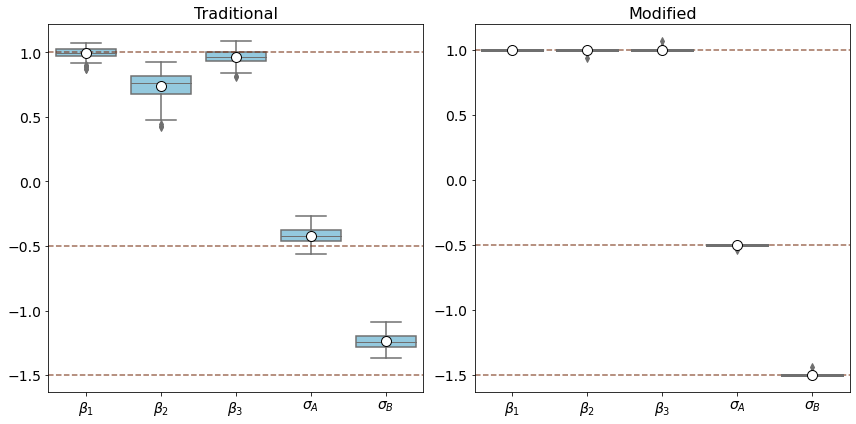

In [8]:
df_0_classic_filtered.columns = [r'$\beta_{1}$', r'$\beta_{2}$', r'$\beta_{3}$', r'$\sigma_{A}$', r'$\sigma_{B}$']
df_0_modified.columns = [r'$\beta_{1}$', r'$\beta_{2}$', r'$\beta_{3}$', r'$\sigma_{A}$', r'$\sigma_{B}$']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.boxplot(x="variable", y="value",data=pd.melt(df_0_classic_filtered), ax=axes[0], showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"},
            medianprops = {"linewidth": 1},
            color = 'skyblue')
axes[0].set_title('Traditional',fontsize=16)
axes[0].axhline(y=1.0, color='#783114', linestyle='--', linewidth=1.5, alpha=0.7)
axes[0].axhline(y=-0.5, color='#783114', linestyle='--', linewidth=1.5, alpha=0.7)
axes[0].axhline(y=-1.5, color='#783114', linestyle='--', linewidth=1.5, alpha=0.7)

axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].tick_params(axis='both', labelsize=14)

sns.boxplot(x="variable", y="value",data=pd.melt(df_0_modified), ax=axes[1], showmeans=True,
            meanprops = {"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"},
            medianprops = {"linewidth": 3},
            color = 'skyblue')

axes[1].set_title('Modified',fontsize=16)
axes[1].axhline(y=1.0, color='#783114', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1].axhline(y=-0.5, color='#783114', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1].axhline(y=-1.5, color='#783114', linestyle='--', linewidth=1.5, alpha=0.7)

axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.savefig("../results/classic_vs_modified.png", dpi=300)
plt.show()

# Visualization of Repeated Simulation Results With Noise

In [11]:
# read csv
df_5 = pd.read_csv("../results/5%Noise.csv")
df_10 = pd.read_csv("../results/10%Noise.csv")
df_25 = pd.read_csv("../results/25%Noise.csv")

# Append suffix to column names based on DataFrame
df_5.columns = [str(col) + "_5" for col in df_5.columns]
df_10.columns = [str(col) + "_10" for col in df_10.columns]
df_25.columns = [str(col) + "_25" for col in df_25.columns]

# Combine the dataframes
df_combined = pd.concat([df_5, df_10, df_25], axis=1)

In [ ]:
################################
# Create a 3 by 3 grids figure #
################################
fig, axs = plt.subplots(3, 3, figsize=(18, 18))

for ax in axs[0]:
    ax.set_ylim([0.7, 1.4])

#################################################
# Boxplot of coefficients - 5% noise levels #
#################################################

# Extract the relevant columns and plot them
ax = axs[0,0]

columns_to_plot = ["beta_x1_5", "beta_s_x2_5", "beta_s_pois_5"]
labels = [r"$\beta_{1}$", r"$\beta_{2}$", r"$\beta_{3}$"]

# Create boxplot
ax.boxplot([df_combined[col] for col in columns_to_plot], labels=labels)
ax.set_ylabel("Value", fontsize = 14)
ax.tick_params(axis='both', labelsize=12)
ax.set_title("Coefficients - 5% Noise",fontsize=16)

##################################################
# Boxplot of coefficients - 10% noise levels #
##################################################

# Extract the relevant columns and plot them
ax = axs[0,1]

columns_to_plot = ["beta_x1_10", "beta_s_x2_10", "beta_s_pois_10"]
labels = [r"$\beta_{1}$", r"$\beta_{2}$", r"$\beta_{3}$"]

# Create boxplot
ax.boxplot([df_combined[col] for col in columns_to_plot], labels=labels)
ax.tick_params(axis='both', labelsize=12)
ax.set_title("Coefficients - 10% Noise",fontsize=16)

##################################################
# Boxplot of coefficients - 25% noise levels #
##################################################

# Extract the relevant columns and plot them
ax = axs[0,2]

columns_to_plot = ["beta_x1_25", "beta_s_x2_25", "beta_s_pois_25"]
labels = [r"$\beta_{1}$", r"$\beta_{2}$", r"$\beta_{3}$"]

# Create boxplot
ax.boxplot([df_combined[col] for col in columns_to_plot], labels=labels)
ax.tick_params(axis='both', labelsize=12)
ax.set_title("Coefficients - 25% Noise", fontsize=16)

#########################################################
# Confidence intervals of sigma of s(X2) - 5% noise levels #
#########################################################

ax = axs[1,0]

# Prepare data frames.
s1_awci_5 = pd.DataFrame({
    'sigma_s_x2': df_combined.sigma_s_x2_5,
    'lower_bound_aw': df_combined.lb_awci_sigma_s_x2_5,
    'upper_bound_aw': df_combined.ub_awci_sigma_s_x2_5
})

s1_rbci_5 = pd.DataFrame({
    'sigma_s_x2': df_combined.sigma_s_x2_5,
    'lower_bound_rb': df_combined.lb_rbci_sigma_s_x2_5,
    'upper_bound_rb': df_combined.ub_rbci_sigma_s_x2_5
})

# Sort the DataFrames
s1_awci_5 = s1_awci_5.sort_values(by='sigma_s_x2')
s1_rbci_5 = s1_rbci_5.sort_values(by='sigma_s_x2')

# True value of sigma.
true_value = -0.5

# Define colors for AW-CIs and RB-CIs.
color_aw = '#FF6347'
color_rb = '#1E90FF' 

# Plotting RB-CIs.
for x, lower, upper in zip(range(100), s1_rbci_5['lower_bound_rb'], s1_rbci_5['upper_bound_rb']):
    ax.vlines(x, lower, upper, color=color_rb, linestyle='-', linewidth=1.5, alpha=0.7)

# Plotting AW-CIs.
for x, lower, upper in zip(range(100), s1_awci_5['lower_bound_aw'], s1_awci_5['upper_bound_aw']):
    ax.vlines(x, lower, upper, color=color_aw, linestyle='-', linewidth=1.5, alpha=0.7)

# Plot the upper and lower bounds for both AW-CIs and RB-CIs.
ax.scatter(range(100), s1_awci_5['lower_bound_aw'], marker='_', color =color_aw, alpha=0.7, s=30)
ax.scatter(range(100), s1_awci_5['upper_bound_aw'], marker='_', color =color_aw, alpha=0.7, s=30)
ax.scatter(range(100), s1_rbci_5['lower_bound_rb'], marker='_', color =color_rb, alpha=0.7, s=30)
ax.scatter(range(100), s1_rbci_5['upper_bound_rb'], marker='_', color =color_rb, alpha=0.7, s=30)

# Plot the estimations.
ax.plot(range(100), s1_awci_5['sigma_s_x2'].to_numpy(), color='black', linestyle='-', marker='')

# Draw the line for the true value.
ax.axhline(y=true_value, color='black', linestyle='--')

# Create legend elements.
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', label=r'True $\sigma_{X_{2}}$', linestyle='--'),
    Line2D([0], [0], color='black', label=r'Estimated $\sigma_{X_{2}}$', linestyle='-'),
    Line2D([0], [0], color=color_aw, label='Akaike Weight CIs', linestyle='-'), 
    Line2D([0], [0], color=color_rb, label='Residual Bootstrap CIs', linestyle='-'),  
]

# Add elements to legend.
ax.legend(handles=legend_elements, loc='lower right', fontsize = 12)

# Labels and title.
ax.set_xlabel('Rank of Estimate Magnitude', fontsize = 14)
ax.set_ylabel("Value", fontsize = 14)
ax.tick_params(axis='both', labelsize=12)
ax.set_title('CIs for $\sigma_{X_{2}}$ Estimates - 5% Noise',fontsize=16)

#########################################################
# Confidence intervals of sigma of s(X2) - 10% noise levels #
#########################################################

ax = axs[1,1]

# Prepare data frames.
s1_awci_10 = pd.DataFrame({
    'sigma_s_x2': df_combined.sigma_s_x2_10,
    'lower_bound_aw': df_combined.lb_awci_sigma_s_x2_10,
    'upper_bound_aw': df_combined.ub_awci_sigma_s_x2_10
})

s1_rbci_10 = pd.DataFrame({
    'sigma_s_x2': df_combined.sigma_s_x2_10,
    'lower_bound_rb': df_combined.lb_rbci_sigma_s_x2_10,
    'upper_bound_rb': df_combined.ub_rbci_sigma_s_x2_10
})

# Sort the DataFrames
s1_awci_10 = s1_awci_10.sort_values(by='sigma_s_x2')
s1_rbci_10 = s1_rbci_10.sort_values(by='sigma_s_x2')

# True value of sigma.
true_value = -0.5

# Define colors for AW-CIs and RB-CIs.
color_aw = '#FF6347'
color_rb = '#1E90FF' 

# Plotting RB-CIs.
for x, lower, upper in zip(range(100), s1_rbci_10['lower_bound_rb'], s1_rbci_10['upper_bound_rb']):
    ax.vlines(x, lower, upper, color=color_rb, linestyle='-', linewidth=1.5, alpha=0.7)

# Plotting AW-CIs.
for x, lower, upper in zip(range(100), s1_awci_10['lower_bound_aw'], s1_awci_10['upper_bound_aw']):
    ax.vlines(x, lower, upper, color=color_aw, linestyle='-', linewidth=1.5, alpha=0.7)

# Plot the upper and lower bounds for both AW-CIs and RB-CIs.
ax.scatter(range(100), s1_awci_10['lower_bound_aw'], marker='_', color =color_aw, alpha=0.7, s=30)
ax.scatter(range(100), s1_awci_10['upper_bound_aw'], marker='_', color =color_aw, alpha=0.7, s=30)
ax.scatter(range(100), s1_rbci_10['lower_bound_rb'], marker='_', color =color_rb, alpha=0.7, s=30)
ax.scatter(range(100), s1_rbci_10['upper_bound_rb'], marker='_', color =color_rb, alpha=0.7, s=30)

# Plot the estimations.
ax.plot(range(100), s1_awci_10['sigma_s_x2'].to_numpy(), color='black', linestyle='-', marker='')

# Draw the line for the true value.
ax.axhline(y=true_value, color='black', linestyle='--')

# Create legend elements.
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', label=r'True $\sigma_{X_{2}}$', linestyle='--'),
    Line2D([0], [0], color='black', label=r'Estimated $\sigma_{X_{2}}$', linestyle='-'),
    Line2D([0], [0], color=color_aw, label='Akaike Weight CIs', linestyle='-'), 
    Line2D([0], [0], color=color_rb, label='Residual Bootstrap CIs', linestyle='-'),  
]

# Add elements to legend.
ax.legend(handles=legend_elements, loc='lower right', fontsize = 12)

# Labels and title.
ax.set_xlabel('Rank of Estimate Magnitude', fontsize = 14)
ax.tick_params(axis='both', labelsize=12)
ax.set_title('CIs for $\sigma_{X_{2}}$ Estimates - 10% Noise', fontsize=16)

#########################################################
# Confidence intervals of sigma s(X2) - 25% noise levels #
#########################################################

ax = axs[1,2]

# Prepare data frames.
s1_awci_25 = pd.DataFrame({
    'sigma_s_x2': df_combined.sigma_s_x2_25,
    'lower_bound_aw': df_combined.lb_awci_sigma_s_x2_25,
    'upper_bound_aw': df_combined.ub_awci_sigma_s_x2_25
})

s1_rbci_25 = pd.DataFrame({
    'sigma_s_x2': df_combined.sigma_s_x2_25,
    'lower_bound_rb': df_combined.lb_rbci_sigma_s_x2_25,
    'upper_bound_rb': df_combined.ub_rbci_sigma_s_x2_25
})

# Sort the DataFrames
s1_awci_25 = s1_awci_25.sort_values(by='sigma_s_x2')
s1_rbci_25 = s1_rbci_25.sort_values(by='sigma_s_x2')

# True value of sigma.
true_value = -0.5

# Define colors for AW-CIs and RB-CIs.
color_aw = '#FF6347'
color_rb = '#1E90FF' 

# Plotting RB-CIs.
for x, lower, upper in zip(range(100), s1_rbci_25['lower_bound_rb'], s1_rbci_25['upper_bound_rb']):
    ax.vlines(x, lower, upper, color=color_rb, linestyle='-', linewidth=1.5, alpha=0.7)

# Plotting AW-CIs.
for x, lower, upper in zip(range(100), s1_awci_25['lower_bound_aw'], s1_awci_25['upper_bound_aw']):
    ax.vlines(x, lower, upper, color=color_aw, linestyle='-', linewidth=1.5, alpha=0.7)

# Plot the upper and lower bounds for both AW-CIs and RB-CIs.
ax.scatter(range(100), s1_awci_25['lower_bound_aw'], marker='_', color =color_aw, alpha=0.7, s=30)
ax.scatter(range(100), s1_awci_25['upper_bound_aw'], marker='_', color =color_aw, alpha=0.7, s=30)
ax.scatter(range(100), s1_rbci_25['lower_bound_rb'], marker='_', color =color_rb, alpha=0.7, s=30)
ax.scatter(range(100), s1_rbci_25['upper_bound_rb'], marker='_', color =color_rb, alpha=0.7, s=30)

# Plot the estimations.
ax.plot(range(100), s1_awci_25['sigma_s_x2'].to_numpy(), color='black', linestyle='-', marker='')

# Draw the line for the true value.
ax.axhline(y=true_value, color='black', linestyle='--')

# Create legend elements.
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', label=r'True $\sigma_{X_{2}}$', linestyle='--'),
    Line2D([0], [0], color='black', label=r'Estimated $\sigma_{X_{2}}$', linestyle='-'),
    Line2D([0], [0], color=color_aw, label='AW CIs', linestyle='-'), 
    Line2D([0], [0], color=color_rb, label='RB CIs', linestyle='-'),  
]

# Add elements to legend.
ax.legend(handles=legend_elements, loc='lower right', fontsize = 12)

# Labels and title.
ax.set_xlabel('Rank of Estimate Magnitude', fontsize = 14)
ax.tick_params(axis='both', labelsize=12)
ax.set_title('CIs for $\sigma_{X_{2}}$ Estimates - 25% Noise', fontsize=16)

#########################################################
# Confidence intervals of sigma of s(POIs) - 5% noise levels #
#########################################################

ax = axs[2,0]

# Prepare data frames.
s2_awci_5 = pd.DataFrame({
    'sigma_s_pois': df_combined.sigma_s_pois_5,
    'lower_bound_aw': df_combined.lb_awci_sigma_s_pois_5,
    'upper_bound_aw': df_combined.ub_awci_sigma_s_pois_5
})

s2_rbci_5 = pd.DataFrame({
    'sigma_s_pois': df_combined.sigma_s_pois_5,
    'lower_bound_rb': df_combined.lb_rbci_sigma_s_pois_5,
    'upper_bound_rb': df_combined.ub_rbci_sigma_s_pois_5
})

# Sort the DataFrames
s2_awci_5 = s2_awci_5.sort_values(by='sigma_s_pois')
s2_rbci_5 = s2_rbci_5.sort_values(by='sigma_s_pois')

# True value of sigma.
true_value = -1.5

# Define colors for AW-CIs and RB-CIs.
color_aw = '#FF6347'
color_rb = '#1E90FF' 

# Plotting RB-CIs.
for x, lower, upper in zip(range(100), s2_rbci_5['lower_bound_rb'], s2_rbci_5['upper_bound_rb']):
    ax.vlines(x, lower, upper, color=color_rb, linestyle='-', linewidth=1.5, alpha=0.7)

# Plotting AW-CIs.
for x, lower, upper in zip(range(100), s2_awci_5['lower_bound_aw'], s2_awci_5['upper_bound_aw']):
    ax.vlines(x, lower, upper, color=color_aw, linestyle='-', linewidth=1.5, alpha=0.7)

# Plot the upper and lower bounds for both AW-CIs and RB-CIs.
ax.scatter(range(100), s2_awci_5['lower_bound_aw'], marker='_', color =color_aw, alpha=0.7, s=30)
ax.scatter(range(100), s2_awci_5['upper_bound_aw'], marker='_', color =color_aw, alpha=0.7, s=30)
ax.scatter(range(100), s2_rbci_5['lower_bound_rb'], marker='_', color =color_rb, alpha=0.7, s=30)
ax.scatter(range(100), s2_rbci_5['upper_bound_rb'], marker='_', color =color_rb, alpha=0.7, s=30)

# Plot the estimations.
ax.plot(range(100), s2_awci_5['sigma_s_pois'].to_numpy(), color='black', linestyle='-', marker='')

# Draw the line for the true value.
ax.axhline(y=true_value, color='black', linestyle='--')

# Create legend elements.
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', label=r'True $\sigma_{X_{POIs}}$', linestyle='--'),
    Line2D([0], [0], color='black', label=r'Estimated $\sigma_{X_{POIs}}$', linestyle='-'),
    Line2D([0], [0], color=color_aw, label='Akaike Weight CIs', linestyle='-'), 
    Line2D([0], [0], color=color_rb, label='Residual Bootstrap CIs', linestyle='-'),  
]

# Add elements to legend.
ax.legend(handles=legend_elements, loc='lower right', fontsize = 12)

# Labels and title.
ax.set_xlabel('Rank of Estimate Magnitude', fontsize = 14)
ax.set_ylabel("Value", fontsize = 14)
ax.tick_params(axis='both', labelsize=12)
ax.set_title('CIs for $\sigma_{X_{POIs}}$ Estimates - 5% Noise', fontsize=16)

#########################################################
# Confidence intervals of sigma of s(POIs) - 10% noise levels #
#########################################################

ax = axs[2,1]

# Prepare data frames.
s2_awci_10 = pd.DataFrame({
    'sigma_s_pois': df_combined.sigma_s_pois_10,
    'lower_bound_aw': df_combined.lb_awci_sigma_s_pois_10,
    'upper_bound_aw': df_combined.ub_awci_sigma_s_pois_10
})

s2_rbci_10 = pd.DataFrame({
    'sigma_s_pois': df_combined.sigma_s_pois_10,
    'lower_bound_rb': df_combined.lb_rbci_sigma_s_pois_10,
    'upper_bound_rb': df_combined.ub_rbci_sigma_s_pois_10
})

# Sort the DataFrames
s2_awci_10 = s2_awci_10.sort_values(by='sigma_s_pois')
s2_rbci_10 = s2_rbci_10.sort_values(by='sigma_s_pois')

# True value of sigma.
true_value = -1.5

# Define colors for AW-CIs and RB-CIs.
color_aw = '#FF6347'
color_rb = '#1E90FF' 

# Plotting RB-CIs.
for x, lower, upper in zip(range(100), s2_rbci_10['lower_bound_rb'], s2_rbci_10['upper_bound_rb']):
    ax.vlines(x, lower, upper, color=color_rb, linestyle='-', linewidth=1.5, alpha=0.7)

# Plotting AW-CIs.
for x, lower, upper in zip(range(100), s2_awci_10['lower_bound_aw'], s2_awci_10['upper_bound_aw']):
    ax.vlines(x, lower, upper, color=color_aw, linestyle='-', linewidth=1.5, alpha=0.7)

# Plot the upper and lower bounds for both AW-CIs and RB-CIs.
ax.scatter(range(100), s2_awci_10['lower_bound_aw'], marker='_', color =color_aw, alpha=0.7, s=30)
ax.scatter(range(100), s2_awci_10['upper_bound_aw'], marker='_', color =color_aw, alpha=0.7, s=30)
ax.scatter(range(100), s2_rbci_10['lower_bound_rb'], marker='_', color =color_rb, alpha=0.7, s=30)
ax.scatter(range(100), s2_rbci_10['upper_bound_rb'], marker='_', color =color_rb, alpha=0.7, s=30)

# Plot the estimations.
ax.plot(range(100), s2_awci_10['sigma_s_pois'].to_numpy(), color='black', linestyle='-', marker='')

# Draw the line for the true value.
ax.axhline(y=true_value, color='black', linestyle='--')

# Create legend elements.
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', label=r'True $\sigma_{X_{POIs}}$', linestyle='--'),
    Line2D([0], [0], color='black', label=r'Estimated $\sigma_{X_{POIs}}$', linestyle='-'),
    Line2D([0], [0], color=color_aw, label='Akaike Weight CIs', linestyle='-'), 
    Line2D([0], [0], color=color_rb, label='Residual Bootstrap CIs', linestyle='-'),  
]

# Add elements to legend.
ax.legend(handles=legend_elements, loc='lower right', fontsize = 12)

# Labels and title.
ax.set_xlabel('Rank of Estimate Magnitude', fontsize = 14)
ax.tick_params(axis='both', labelsize=12)
ax.set_title('CIs for $\sigma_{X_{POIs}}$ Estimates - 10% Noise', fontsize=16)

#########################################################
# Confidence intervals of sigma of s(POIs) - 25% noise levels #
#########################################################

ax = axs[2,2]

# Prepare data frames.
s2_awci_25 = pd.DataFrame({
    'sigma_s_pois': df_combined.sigma_s_pois_25,
    'lower_bound_aw': df_combined.lb_awci_sigma_s_pois_25,
    'upper_bound_aw': df_combined.ub_awci_sigma_s_pois_25
})

s2_rbci_25 = pd.DataFrame({
    'sigma_s_pois': df_combined.sigma_s_pois_25,
    'lower_bound_rb': df_combined.lb_rbci_sigma_s_pois_25,
    'upper_bound_rb': df_combined.ub_rbci_sigma_s_pois_25
})

# Sort the DataFrames
s2_awci_25 = s2_awci_25.sort_values(by='sigma_s_pois')
s2_rbci_25 = s2_rbci_25.sort_values(by='sigma_s_pois')

# True value of sigma.
true_value = -1.5

# Define colors for AW-CIs and RB-CIs.
color_aw = '#FF6347'
color_rb = '#1E90FF' 

# Plotting RB-CIs.
for x, lower, upper in zip(range(100), s2_rbci_25['lower_bound_rb'], s2_rbci_25['upper_bound_rb']):
    ax.vlines(x, lower, upper, color=color_rb, linestyle='-', linewidth=1.5, alpha=0.7)

# Plotting AW-CIs.
for x, lower, upper in zip(range(100), s2_awci_25['lower_bound_aw'], s2_awci_25['upper_bound_aw']):
    ax.vlines(x, lower, upper, color=color_aw, linestyle='-', linewidth=1.5, alpha=0.7)

# Plot the upper and lower bounds for both AW-CIs and RB-CIs.
ax.scatter(range(100), s2_awci_25['lower_bound_aw'], marker='_', color =color_aw, alpha=0.7, s=30)
ax.scatter(range(100), s2_awci_25['upper_bound_aw'], marker='_', color =color_aw, alpha=0.7, s=30)
ax.scatter(range(100), s2_rbci_25['lower_bound_rb'], marker='_', color =color_rb, alpha=0.7, s=30)
ax.scatter(range(100), s2_rbci_25['upper_bound_rb'], marker='_', color =color_rb, alpha=0.7, s=30)

# Plot the estimations.
ax.plot(range(100), s2_awci_25['sigma_s_pois'].to_numpy(), color='black', linestyle='-', marker='')

# Draw the line for the true value.
ax.axhline(y=true_value, color='black', linestyle='--')

# Create legend elements.
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', label=r'True $\sigma_{X_{POIs}}$', linestyle='--'), 
    Line2D([0], [0], color='black', label=r'Estimated $\sigma_{X_{POIs}}$', linestyle='-'),
    Line2D([0], [0], color=color_aw, label='Akaike Weights CIs', linestyle='-'), 
    Line2D([0], [0], color=color_rb, label='Residual Bootstrap CIs', linestyle='-'),  
]

# Add elements to legend.
ax.legend(handles=legend_elements, loc='lower right', fontsize = 12)

# Labels and title.
ax.set_xlabel('Rank of Estimate Magnitude', fontsize = 14)
ax.tick_params(axis='both', labelsize=12)
ax.set_title('CIs for $\sigma_{X_{POIs}}$ Estimates - 25% Noise', fontsize=16)

# Save and show the figure.
plt.tight_layout()
plt.savefig("../results/repeated_simulation_results.png", dpi=300)
plt.show()